# 📚 **Installation**

In [1]:
import bz2
import time
import mlflow
import joblib
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna.visualization as ov
from bokeh.io import export_svgs
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, show
from bokeh.palettes import viridis, cividis
from bokeh.models import ColumnDataSource, Range1d
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score
from textwrap import wrap
from matplotlib.cm import get_cmap
# from optuna.exceptions import TrialPruned

import ipywidgets
import mlflow.sklearn
from optuna.integration import MLflowCallback
from sklearn.experimental import enable_hist_gradient_boosting

from tqdm import tqdm
from mlflow.tracking import MlflowClient

from bokeh.palettes import viridis, cividis
viridis_palette = viridis(256)

from OptimizingUtils.tunePipeline import tunePipeline as tp


C:\Users\decla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# ⚠️ **Warnings**

In [3]:
import logging
import warnings

logging.basicConfig(level=logging.INFO)
logging.disable(logging.WARNING)

optuna.logging.disable_default_handler()
pd.options.mode.chained_assignment = None 
optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 📂 **Data**

In [4]:
# Create a DataFrame from CSV data
result_df = pd.read_csv("FE_golf.csv")

# 🍽️ **Pre-Processing**

In [5]:
# Assume result_df is already defined and preprocessed up to this point
result_df = result_df[result_df['from_location_scorer'] == 'Green']
result_df = result_df.drop(columns=['from_location_scorer', 'from_location_laser'])

# Feature columns and target column
feature_cols = ["ISS", "ISC", 'slope', 'elevation',
                'putting_dist_from_center_bins','putting_distance_to_pin_bins','putting_dist_from_edge_bins', 'CSI', 'round', 'first_putt', 'par_value',
                'distance_to_pin', 'dist_from_edge', 'pin_minus_edge', 'SSI', 'hole_completeness', 
                'dist_from_center']
categorical_cols = ['round', 'par_value', 'slope', 
                    'elevation', 'putting_dist_from_center_bins','putting_dist_from_edge_bins','putting_distance_to_pin_bins', 'first_putt']
numerical_cols = ["ISS", "ISC", "distance_to_pin", "dist_from_edge", "pin_minus_edge", 
                  "SSI", "hole_completeness", "dist_from_center"]

# 🔪 **Split**

In [7]:
X = result_df[feature_cols]
y = result_df['strokes_to_hole_out']

# Extract the columns for stratification
stratify_cols = ['putting_distance_to_pin_bins','putting_dist_from_center_bins','putting_dist_from_edge_bins']
stratify_data = result_df[stratify_cols]

# Split the data, using 'stratify_data' for stratification
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_data)

# 🔄 **MLFlow**

Navigate to the terminal and create an MLFlow instance:

``` console

mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 0.0.0.0 --port 8080

```

In [8]:
mlflow.set_tracking_uri("http://localhost:8080")

# Custom prunce & Sampler for Optuna
pruner = optuna.pruners.MedianPruner()
sampler = optuna.samplers.CmaEsSampler()

#amount of trials per model
trials_todo =16

base_models = []

# 🎶🎷 **Tune Base GradientBoostingRegressor**

In [9]:
experiment_name = "Base GradientBoostingRegressor"
mlflow.set_experiment(experiment_name)
GradientBoostingRegressor_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Define a function to suggest hyperparameters for GradientBoostingRegressor
def gradient_boosting_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 150, 600),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_uniform("subsample", 0.4, 0.8),
        "min_samples_split": trial.suggest_int("min_samples_split", 4, 8),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 3, 7),
        "max_features": trial.suggest_uniform("max_features", 0.4, 0.99),
    }

with tqdm(total=trials_todo) as pbar:
    def update_progress(GradientBoostingRegressor_study, trial):
        pbar.update(1)

    # Use the objective function with the GradientBoostingRegressor
    GradientBoostingRegressor_study.optimize(lambda trial: tp.objective(trial, GradientBoostingRegressor, gradient_boosting_params,categorical_cols=categorical_cols, numerical_cols=numerical_cols, X=X, y=y), n_trials=trials_todo, callbacks=[update_progress])

# log and register best model to prod
best_best_GradientBoostingRegressor_model_trial = tp.log_and_print_best_trial(GradientBoostingRegressor_study)
best_GradientBoostingRegressor_model, model_version = tp.register_best_model(best_best_GradientBoostingRegressor_model_trial)
base_models.append(best_GradientBoostingRegressor_model)
best_GradientBoostingRegressor_model

100%|██████████| 16/16 [17:25<00:00, 65.32s/it]  


Best trial:
  Value: 0.0371
  Params: 
    scaler: power
    encoder: ordinal
    numerical_imputer_strategy: median
    categorical_imputer_strategy: constant
    feature_selector: none
    poly_degree: 2
    n_estimators: 247
    learning_rate: 0.028052739836613744
    max_depth: 5
    subsample: 0.6707230366429975
    min_samples_split: 7
    min_samples_leaf: 5
    max_features: 0.5515423500709773


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['ISS', 'ISC',
                                                   'distance_to_pin',
                                                   'dist_from_edge',
                                                   'pin_minus_edge', 'SSI',
                                                   'hole_completeness',
                                                   'dist_from_center']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strat...
                                                   'putting_dist_from_edge_bins',
                                                   'putting_distance_to_pin_bins',
                                                   'first_putt']),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False),
                                                  [])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.028052739836613744,
                                           max_depth=5,
                                           max_features=0.5515423500709773,
                                           min_samples_leaf=5,
                                           min_samples_split=7,
                                           n_estimators=247, random_state=42,
                                           subsample=0.6707230366429975))])

In [10]:
ov.plot_optimization_history(GradientBoostingRegressor_study)

In [11]:
ov.plot_param_importances(GradientBoostingRegressor_study)

In [12]:
ov.plot_contour(GradientBoostingRegressor_study, params=["encoder", "scaler"])

# 🎶🎷 **Tune Base AdaBoostRegressor**

In [13]:
experiment_name = "AdaBoostRegressor"
mlflow.set_experiment(experiment_name)
AdaBoostRegressor_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Define a function to suggest hyperparameters for AdaBoostRegressor
def AdaBoostRegressorg_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 20, 600),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
    }

with tqdm(total=trials_todo) as pbar:
    def update_progress(AdaBoostRegressor_study, trial):
        pbar.update(1)

    # Use the objective function with the AdaBoostRegressor
    AdaBoostRegressor_study.optimize(lambda trial: tp.objective(trial, AdaBoostRegressor, AdaBoostRegressorg_params, categorical_cols=categorical_cols, numerical_cols=numerical_cols, X=X, y=y), n_trials=trials_todo, callbacks=[update_progress])

# log and register best model to prod
best_AdaBoostRegressor_trial = tp.log_and_print_best_trial(AdaBoostRegressor_study)
best_AdaBoostRegressor_model, model_version = tp.register_best_model(best_AdaBoostRegressor_trial)
base_models.append(best_AdaBoostRegressor_model)
best_AdaBoostRegressor_model

100%|██████████| 16/16 [26:33<00:00, 99.59s/it] 


Best trial:
  Value: 0.0331
  Params: 
    scaler: robust
    encoder: ordinal
    numerical_imputer_strategy: constant
    categorical_imputer_strategy: most_frequent
    feature_selector: kbest
    k: 11
    poly_degree: 1
    n_estimators: 29
    learning_rate: 0.0012578994205573177


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['ISS', 'ISC',
                                                   'distance_to_pin',
                                                   'dist_from_edge',
                                                   'pin_minus_edge', 'SSI',
                                                   'hole_completeness',
                                                   'dist_from_center']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most...
                                                  ['round', 'par_value',
                                                   'slope', 'elevation',
                                                   'putting_dist_from_center_bins',
                                                   'putting_dist_from_edge_bins',
                                                   'putting_distance_to_pin_bins',
                                                   'first_putt']),
                                                 ('feature_selector',
                                                  SelectKBest(k=11,
                                                              score_func=<function f_regression at 0x000001FA548BCE50>),
                                                  [])])),
                ('regressor',
                 AdaBoostRegressor(learning_rate=0.0012578994205573177,
                                   n_estimators=29, random_state=42))])

In [14]:
ov.plot_optimization_history(AdaBoostRegressor_study)

In [15]:
ov.plot_param_importances(AdaBoostRegressor_study)

In [16]:
ov.plot_contour(AdaBoostRegressor_study, params=["encoder", "scaler"])

# 🎶🎷 **Tune Base RandomForestRegressor**

In [17]:
experiment_name = "RandomForestRegressor"
mlflow.set_experiment(experiment_name)
RandomForestRegressor_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Define a function to suggest hyperparameters for RandomForestRegressor
def RandomForestRegressor_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_uniform("max_features", 0.1, 1.0),
    }

with tqdm(total=trials_todo) as pbar:
    def update_progress(RandomForestRegressor_study, trial):
        pbar.update(1)

    # Use the objective function with the RandomForestRegressor
    RandomForestRegressor_study.optimize(lambda trial: tp.objective(trial, RandomForestRegressor, RandomForestRegressor_params,categorical_cols=categorical_cols, numerical_cols=numerical_cols, X=X, y=y), n_trials=trials_todo, callbacks=[update_progress])

# log and register best model to prod
best_RandomForestRegressor_trial = tp.log_and_print_best_trial(RandomForestRegressor_study)
best_RandomForestRegressor_model, model_version = tp.register_best_model(best_RandomForestRegressor_trial)
base_models.append(best_RandomForestRegressor_model)
best_RandomForestRegressor_model

100%|██████████| 16/16 [10:07<00:00, 37.96s/it]


Best trial:
  Value: 0.0345
  Params: 
    scaler: robust
    encoder: binary
    numerical_imputer_strategy: mean
    categorical_imputer_strategy: most_frequent
    feature_selector: model
    poly_degree: 3
    n_estimators: 593
    max_depth: 5
    min_samples_split: 7
    min_samples_leaf: 4
    max_features: 0.7941943056118059


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['ISS', 'ISC',
                                                   'distance_to_pin',
                                                   'dist_from_edge',
                                                   'pin_minus_edge', 'SSI',
                                                   'hole_completeness',
                                                   'dist_from_center']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   BinaryEnc...
                                                   'putting_distance_to_pin_bins',
                                                   'first_putt']),
                                                 ('feature_selector',
                                                  SelectFromModel(estimator=GradientBoostingRegressor(n_estimators=50)),
                                                  []),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  [])])),
                ('regressor',
                 RandomForestRegressor(max_depth=5,
                                       max_features=0.7941943056118059,
                                       min_samples_leaf=4, min_samples_split=7,
                                       n_estimators=593, random_state=42))])

In [18]:
ov.plot_optimization_history(RandomForestRegressor_study)

In [19]:
ov.plot_param_importances(RandomForestRegressor_study)

In [20]:
ov.plot_contour(RandomForestRegressor_study, params=["encoder", "scaler"])

# 🎶🎷 **Tune Base MLPRegressor**

In [21]:
experiment_name = "MLPRegressor_params_study"
mlflow.set_experiment(experiment_name)
MLPRegressor_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Define a function to suggest hyperparameters for MLPRegressor_params_study
def MLPRegressor_params(trial):
    return {
        "hidden_layer_sizes": trial.suggest_int("hidden_layer_sizes", 1, 100),
        "alpha": trial.suggest_loguniform("alpha", 1e-6, 1.0),
        "learning_rate_init": trial.suggest_loguniform("learning_rate_init", 1e-7, 1e-1),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
    }

with tqdm(total=trials_todo) as pbar:
    def update_progress(MLPRegressor_study, trial):
        pbar.update(1)

    # Use the objective function with the best_MLPRegressor_model
    MLPRegressor_study.optimize(lambda trial: tp.objective(trial, MLPRegressor, MLPRegressor_params,categorical_cols=categorical_cols, numerical_cols=numerical_cols, X=X, y=y), n_trials=trials_todo, callbacks=[update_progress])

# log and register best model to prod
best_MLPRegressor_trial = tp.log_and_print_best_trial(MLPRegressor_study)
best_MLPRegressor_model, model_version = tp.register_best_model(best_MLPRegressor_trial)
base_models.append(best_MLPRegressor_model)
best_MLPRegressor_model

100%|██████████| 16/16 [10:58<00:00, 41.15s/it]  


Best trial:
  Value: 0.0564
  Params: 
    scaler: quantile
    n_quantiles: 462
    encoder: binary
    numerical_imputer_strategy: constant
    categorical_imputer_strategy: most_frequent
    feature_selector: kbest
    k: 19
    poly_degree: 3
    hidden_layer_sizes: 67
    alpha: 1.9052121653137325e-05
    learning_rate_init: 0.013766081584253506
    max_iter: 387


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   QuantileTransformer(n_quantiles=462,
                                                                                       output_distribution='normal'))]),
                                                  ['ISS', 'ISC',
                                                   'distance_to_pin',
                                                   'dist_from_edge',
                                                   'pin_minus_edge', 'SSI',
                                                   'hole_completeness',
                                                   'dist_from_center']),
                                                 ('cat',
                                                  Pipe...
                                                   'putting_distance_to_pin_bins',
                                                   'first_putt']),
                                                 ('feature_selector',
                                                  SelectKBest(k=19,
                                                              score_func=<function f_regression at 0x000001FA548BCE50>),
                                                  []),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  [])])),
                ('regressor',
                 MLPRegressor(alpha=1.9052121653137325e-05,
                              hidden_layer_sizes=67,
                              learning_rate_init=0.013766081584253506,
                              max_iter=387, random_state=42))])

In [22]:
ov.plot_optimization_history(MLPRegressor_study)

In [23]:
ov.plot_param_importances(MLPRegressor_study)

In [24]:
ov.plot_contour(MLPRegressor_study, params=["encoder", "scaler"])

# 🚂 **Train Final Estimator** 🤖

In [25]:
names = ['GradientBoostingRegressor','AdaBoostRegressor','RandomForestRegressor', 'MLPRegressor']
pairs = list(zip(names, base_models))

experiment_name = "final_estimator"
mlflow.set_experiment(experiment_name)
final_estimator_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Define a function to suggest hyperparameters for final_estimator
def final_estimator_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 150, 600),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_uniform("subsample", 0.4, 0.8),
        "min_samples_split": trial.suggest_int("min_samples_split", 4, 8),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 3, 7),
        "max_features": trial.suggest_uniform("max_features", 0.4, 0.99),
    }

with tqdm(total=trials_todo) as pbar:
    def update_progress(final_estimator_study, trial):
        pbar.update(1)

    # Optimize the StackingRegressor
    final_estimator_study.optimize(
        lambda trial: tp.objective(
            trial, 
            GradientBoostingRegressor, 
            final_estimator_params, 
            is_stacking=True, 
            base_models=pairs,
            categorical_cols=categorical_cols, 
            numerical_cols=numerical_cols, 
            X=X, 
            y=y
        ),
        n_trials=3,
        callbacks=[update_progress]
    )

# Log and register best model to prod
best_final_estimator_trial =tp. log_and_print_best_trial(final_estimator_study)
best_final_estimator_model, model_version = tp.register_best_model(best_final_estimator_trial)
base_models.append(best_final_estimator_model)
print(f"Model registered as version: {model_version.version}")


 19%|█▉        | 3/16 [38:18<2:46:00, 766.20s/it]


Best trial:
  Value: 0.0351
  Params: 
    scaler: maxabs
    encoder: target
    numerical_imputer_strategy: most_frequent
    categorical_imputer_strategy: most_frequent
    feature_selector: kbest
    k: 15
    poly_degree: 2
    n_estimators: 316
    learning_rate: 0.019989302074966988
    max_depth: 4
    subsample: 0.7462471018743315
    min_samples_split: 5
    min_samples_leaf: 5
    max_features: 0.5152405224190484
Model registered as version: 1


In [26]:
best_final_estimator_model

StackingRegressor(estimators=[('GradientBoostingRegressor',
                               Pipeline(steps=[('preprocessor',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='median')),
                                                                                                 ('scaler',
                                                                                                  PowerTransformer())]),
                                                                                 ['ISS',
                                                                                  'ISC',
                                                                                  'distance_to_pin',
                                                                                  'dist_from_edge',
                                                                                  'pin_minus_edge',
                                                                                  'SSI',
                                                                                  'hole_completeness',
                                                                                  'dist_from_center']),
                                                                                ('cat',
                                                                                 Pipeline...
                                                MLPRegressor(alpha=1.9052121653137325e-05,
                                                             hidden_layer_sizes=67,
                                                             learning_rate_init=0.013766081584253506,
                                                             max_iter=387,
                                                             random_state=42))]))],
                  final_estimator=GradientBoostingRegressor(learning_rate=0.019989302074966988,
                                                            max_depth=4,
                                                            max_features=0.5152405224190484,
                                                            min_samples_leaf=5,
                                                            min_samples_split=5,
                                                            n_estimators=316,
                                                            random_state=42,
                                                            subsample=0.7462471018743315))

In [27]:
ov.plot_optimization_history(final_estimator_study)

In [28]:
ov.plot_param_importances(final_estimator_study)

In [29]:
ov.plot_contour(final_estimator_study, params=["encoder", "scaler"])

# **Mean Absolute Error**

In [30]:
# Make predictions on the validation data
preds = best_final_estimator_model.predict(X_valid)

# Extract the predicted distances
predicted_distance = list(preds)
actual_distance = y_valid.to_list()

mae = mean_absolute_error(actual_distance, predicted_distance)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.039106600785486875


# **Partial Dependence Display**

<Figure size 800x600 with 0 Axes>

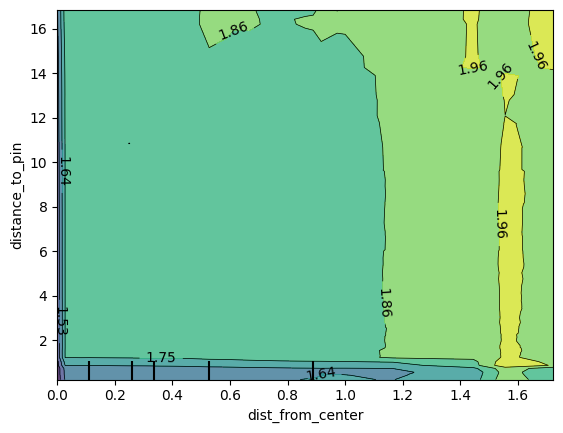

<Figure size 800x600 with 0 Axes>

In [31]:
# Filter the data
X_train_filtered = X_train[X_train['first_putt'] == 'Y']
# X_train_filtered = X_train_filtered[X_train_filtered['distance_to_pin'] < 2]
# X_train_filtered = X_train_filtered[X_train_filtered['dist_from_center'] < 2]

# Plot both features together
f_names = [('dist_from_center', 'distance_to_pin')]
disp = PartialDependenceDisplay.from_estimator(best_final_estimator_model, X_train_filtered[:88], f_names)
plt.figure(figsize=(8, 6))

# **Residuals**

In [32]:
final_pipe_results = pd.DataFrame()

final_pipe_results['predicted_distance'] = predicted_distance

final_pipe_results['actual_distance'] = actual_distance

final_pipe_results['residual'] = final_pipe_results['actual_distance'] - final_pipe_results['predicted_distance']

p = figure(height=300, width=300,title="Predicted vs Actual")
p.circle(actual_distance, predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.3)
p.xaxis.axis_label = 'Actual'
p.yaxis.axis_label = 'Predicted'

z = figure(height=300, width=300,title="Predicted vs Residual")
z.circle(final_pipe_results.residual, final_pipe_results.predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.3)
z.yaxis.axis_label = 'Predicted'
z.xaxis.axis_label = 'Residual'

b = figure(width=600, height=300, toolbar_location=None,
           title="Normality of Residuals")

# Histogram
bins = np.linspace(-0.5, 0.5, 100)
hist, edges = np.histogram(final_pipe_results.residual, density=True, bins=bins)
b.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color=viridis_palette[180], line_color="white")

b.y_range.start = 0
b.x_range.start = -0.5
b.x_range.end = 0.5

b.xaxis.axis_label = "Residuals"
b.yaxis.axis_label = "Distribution Count"

grid = gridplot([[row(p,z)], 
                 [b]])
show(grid)

# **[Permutaion Importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)**

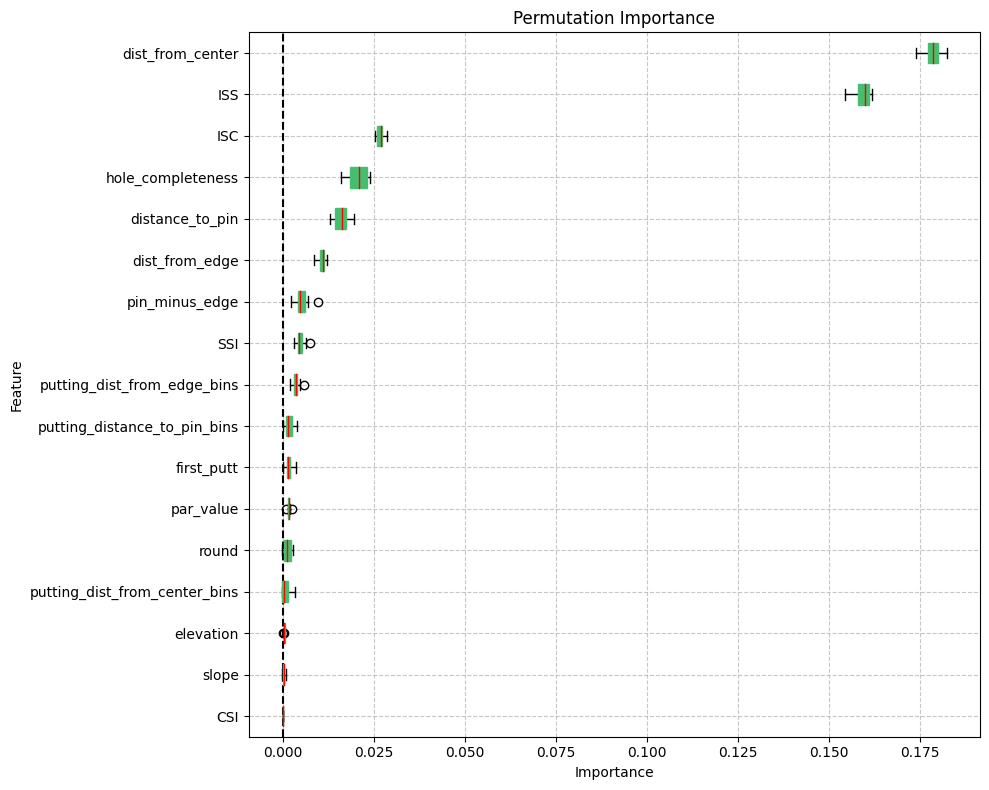

In [33]:
result = permutation_importance(best_final_estimator_model, 
                                X_train, 
                                y_train.values.ravel(), 
                                n_repeats=10,
                                random_state=42)

fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size for better readability and aesthetics

perm_sorted_idx = result.importances_mean.argsort()

# Customize boxplot appearance
box = ax.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    patch_artist=True,  # Enable filling colors
    boxprops=dict(facecolor=viridis_palette[180], color=viridis_palette[180]),  # Box color customization
    whiskerprops=dict(color='black'),  # Whisker color customization
    capprops=dict(color='black'),  # Cap color customization
    medianprops=dict(color='red')  # Median line color customization
)

# Set labels and title
ax.set_yticklabels(X_train.columns[perm_sorted_idx])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Permutation Importance')

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line at x=0
ax.axvline(x=0, color="black", linestyle="--")

# Customize layout
plt.tight_layout()

plt.show()

# 🟢🍋 **Lime**

In [36]:
from lime.lime_tabular import LimeTabularExplainer


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,  train_size=0.95, test_size=0.05, random_state=random_state.randint(1, 101),stratify = X[['home_team',"stand",'grouped_pitch_type']])
#hopefully strat works here?

# Define transformers for categorical and numerical columns
numeric_cols = [col for col in X_train.columns if col not in categorical_features]

categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

numeric_transformer = Pipeline([
    ('scaler', RobustScaler()),
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_cols)
    ])

# Fit and transform the preprocessing pipeline on the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)

# Define a linear regression model
XGBRegressor = XGBRegressor(XGB__learning_rate=0.1, max_depth=5, min_child_weight = 1, subsample = 1.0, n_estimators=10)

RandomForestRegressor = RandomForestRegressor()

MLPRegressor = MLPRegressor()

GradientBoostingRegressor = GradientBoostingRegressor()

lime_er = VotingRegressor([('r1', XGBRegressor), ('r2', RandomForestRegressor),('r3',MLPRegressor),('r4',GradientBoostingRegressor)])
lime_er.fit(X_train_processed, y_train)

# Create a LIME explainer in regression mode
explainer = LimeTabularExplainer(X_train_processed, mode="regression")

# Define a custom predictor function for LIME
def custom_predictor(X):
    #return regressor.predict(X)
    return lime_er.predict(X)

In [ ]:
def final_lime(instance_idx_val):
    #also print which model was chosen?

    print(X_valid.iloc[instance_idx_val])

    explanation = explainer.explain_instance(X_valid_processed[instance_idx_val], custom_predictor)

    explanation.show_in_notebook()

final_lime(np.random.randint(1, 101))

# 📩 **Save**

In [34]:
# with bz2.BZ2File('compressed_putting_model.joblib.bz2', 'wb', compresslevel=9) as f:
#     joblib.dump(best_final_estimator_model, f)